# 线性模型
<!-- 
Author: Zhaoqiang SHEN
Date: 2018/08/22
Contact: szqtclx@gmail.com
-->

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# scikit-learn
from sklearn import linear_model
from sklearn import discriminant_analysis
from sklearn import metrics

np.random.seed(1)

## 线性回归
线性模型：$f({\bf x}) = w_1 x_1 + w_2 x_2 + \cdots + w_d x_d + b = {\bf x}^T { \bf \hat w}$，其中${\bf \hat w}=({\bf w}; b) = (w_1, w_2, \cdots, b)^T$。  
损失函数（欧几里得距离）：
$J({\bf \hat w}) = \sum_{i=1}^{m} [ f({\bf x}^{(i)}; {\bf \hat w}) - y^{(i)} ]^2 = ({\bf Xw-y})^T({\bf Xw-y})$。  
最小化损失函数可得模型参数：
$\boxed{ {\bf \hat w}^\star = ({\bf X}^T {\bf X})^{-1} {\bf X}^T {\bf y}}$, 其中${\bf X}=({\bf x}_1^{T}; {\bf x}_2^{T}; \cdots; {\bf x}_m^{T})$。

**线性回归的特点**  
优点：结果易于理解，计算上不复杂。  
缺点：对非线性的数据拟合不好。  
适用于数据类型：数值型和标称型数据。  

In [2]:
#raw_data = np.loadtxt('datasets/MLiA/Ch08/ex0.txt') # Machine Learning in Action, Chap8
#X = raw_data[:, :-1] # (1., x_1, x_2, ...) for each vector
#y = raw_data[:, -1]

In [3]:
# generate mock data
def mock_generator1(X_raw):
    nsamp = X_raw.shape[0]
    return 1.+X_raw+X_raw**2 + X_raw**3 + 0.4*np.random.randn(nsamp)

# training data
X_raw = np.random.rand(50)
y_raw = mock_generator1(X_raw)
X = np.c_[np.ones_like(X_raw), X_raw]
y = y_raw.reshape(-1, 1)
#print(X, y)

# test data
X_test_raw = np.random.rand(25)
y_test_raw = mock_generator1(X_test_raw)
X_test = np.c_[np.ones_like(X_test_raw), X_test_raw]
y_test = y_test_raw.reshape(-1, 1)

In [4]:
w = np.linalg.inv(X.T @ X) @ X.T @ y
w

array([[0.68431397],
       [2.95919615]])

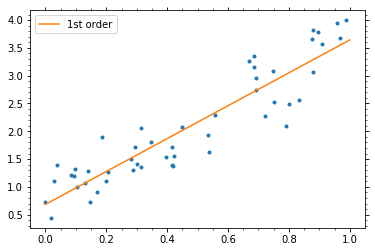

In [5]:
fg0, ax0 = plt.subplots()
ax0.plot(X[:, 1], y, marker='o', ms=3, ls='None')
ax0.plot([0., 1.], np.array([[1, 0], [1, 1]])@w.reshape(2, 1), ls='-', label='1st order')
ax0.legend()

In [6]:
#拟合优度
def rss(y_pred, y_truth):
    """
    Residual sum of squares (RSS)
    
    Parameters
    -------------
    y_pred : numpy array, (m, 1)
        the predicted labels
    y_truth : numpy array, (m, 1)
        the true labels
        
    Returns
    --------
    rss : double
    """
    return ((y_pred-y_truth)**2).sum()

def mse(y_pred, y_truth):
    """
    mean squared error (MSE)

    Parameters
    -------------
    y_pred : numpy array, (m, 1)
        the predicted labels
    y_truth : numpy array, (m, 1)
        the true labels
        
    Returns
    --------
    mse : double
        smaller is better
    """
    return rss(y_pred, y_truth)/y_pred.shape[0]

def rse(y_pred, y_truth):
    """
    residual standard error (RSE):
        estimation of the standard deviation between the
        predicted values and true values

    REF: An Introduction to Statistical Learning, pp. 82-83

    Parameters
    -------------
    y_pred : numpy array, (m, 1), m>30
        the predicted labels
    y_truth : numpy array, (m, 1), m>30
        the true labels
        
    Returns
    --------
    rse : double
        smaller is better
    """
    return np.sqrt(rss(y_pred, y_truth)/(y_pred.shape[0]-2))

def r2(y_pred, y_truth):
    """
    R^2 statistic:
        the proportion of variance explained by the model
        given X
    
    Parameters
    -------------
    y_pred : numpy array, (m, 1)
        the predicted labels
    y_truth : numpy array, (m, 1)
        the true labels
        
    Returns
    --------
    r2 : double, [0, 1]
        larger is better
    """
    tss_ = ((y_truth-y_truth.mean(axis=0))**2).sum()
    rss_ = rss(y_pred, y_truth)
    return 1.-rss_/tss_

def metric_continuous(y_pred, y_truth):
    print('MSE={:.4f}'.format(mse(y_pred, y_truth)))
    print('RSE={:.4f}'.format(rse(y_pred, y_truth)))
    print("R2={:.4%}".format(r2(y_pred, y_truth)))

In [7]:
print('Training set:')
y_pred = X@w # a@b=np.dot(a, b) for Python 3
metric_continuous(y_pred, y)

print('Test set:')
y_test_pred = X_test@w
metric_continuous(y_test_pred, y_test)

Training set:
MSE=0.1475
RSE=0.3920
R2=84.6905%
Test set:
MSE=0.1755
RSE=0.4367
R2=82.7885%


### sklearn

In [8]:
lin = linear_model.LinearRegression()
lin.fit(X[:, 1:], y)
print(lin.intercept_, lin.coef_) # b, w

[0.68431397] [[2.95919615]]


In [9]:
y_pred = lin.predict(X[:, 1:])
print('MSE={:.4f}'.format(metrics.mean_squared_error(y, y_pred)))
print('R^2={:.4%}'.format(metrics.r2_score(y, y_pred)))

MSE=0.1475
R^2=84.6905%


## 线性基函数 （Linear Basis Function）
在某些情况下，特征无法用简单的模型表示，即出现**欠拟合**问题。

欠拟合可以通过将特征向量投影到更高维特征空间（${\bf x} \to \phi({\bf x})$）来使问题可分，其中集合$\{ \phi_i({\bf x})\}$称为**基函数**。  
对于已知的基函数，新的模型可写为：$f({\bf x}) = \sum_j w_j \phi_j({\bf x}) = {\bf\phi(x)}^T\,{\bf \hat w} $，其中$\phi({\bf x})=(\phi_1({\bf x}), \phi_2({\bf x}), \cdots, \phi_n({\bf x}))^T$。  
假设损失函数是欧几里得距离，可解得参数：
${\bf \hat w}^\star = ({\bf \Phi}({\bf X})^T {\bf \Phi}({\bf X}))^{-1} {\bf \Phi}({\bf X})^T {\bf y}$，其中${\bf \Phi}({\bf X}) = (\phi({\bf x}_1)^T; \phi({\bf x}_2)^T; \cdots; \phi({\bf x}_m)^T)$。  
最终模型为：
$\boxed{f({\bf x}) = {\bf \phi}({\bf x})^T {\bf \hat w}^\star = \phi({\bf x})^T \Phi({\bf X})^T (\Phi({\bf X}) \Phi({\bf X})^T)^{-1} {\bf y} = \kappa({\bf X, x}) \kappa({\bf X, X}) ^{-1} {\bf y}  }$ (规范正交基)

In [10]:
def polynomial_expr(x, p=1):
    """
    polynomial expression of a vector
    
    Parameters
    -------------
    x : numpy array, (m, )
    n : integer, >0
    
    Returns
    ---------
    X_out : numpy array, (m, p)
        [1, x, x^2, ..., x^p]
    """
    _x = x.flatten()
    x_polys = [np.ones_like(_x)]
    for i in range(p):
        x_polys.append(x_polys[-1]*_x)
    return np.array(x_polys).T

下面以多项式基函数$\phi_j(x) = x^j, (j=0,1,2,3)$为例：
<!-- $f({\bf x}) = {\bf \phi}({\bf x})^T {\bf \hat w}^\star = \phi({\bf x})^T {\bf \phi}({\bf X}) {\bf y}$ -->

In [11]:
X_lb = polynomial_expr(X_raw, 3) # xm = (1, xm, xm^2, xm^3)
w_lb = np.linalg.inv(X_lb.T @ X_lb) @ X_lb.T @ y
w_lb

array([[0.89683543],
       [1.86985936],
       [0.01225323],
       [1.235891  ]])

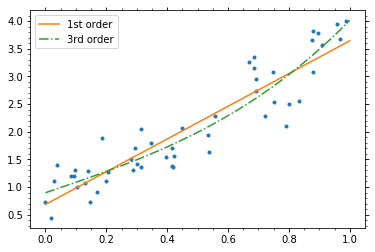

In [12]:
x_pl = np.linspace(0, 1, 100)
y_pl_pred = polynomial_expr(x_pl, 3) @ w_lb
ax0.plot(x_pl, y_pl_pred, ls='-.', label='3rd order')
ax0.legend()
fg0

In [13]:
print('Training set:')
y_pred = X_lb@w_lb
metric_continuous(y_pred, y)

print('Test set:')
y_test_pred = polynomial_expr(X_test_raw, 3)@w_lb
metric_continuous(y_test_pred, y_test)

Training set:
MSE=0.1286
RSE=0.3660
R2=86.6539%
Test set:
MSE=0.1553
RSE=0.4109
R2=84.7634%


### sklearn

In [14]:
lin2 = linear_model.LinearRegression()
lin2.fit(X_lb[:, 1:], y)
print(lin2.intercept_, lin2.coef_) # b, w

[0.89683543] [[1.86985936 0.01225323 1.235891  ]]


## 正则化
训练数据中除了包含特征间的普遍关系，每个样本也会有各自特有的隐参量影响着特征的取值，这些隐参量造成的样本特征在普遍关系上还存在一些未解释的涨落。当模型复杂度足够高时，它可能会去拟合这些统计涨落，即产生**过拟合**问题。因为统计涨落是并非来自于真实的特征间关系，所以过拟合会导致模型泛化能力降低。

正则化通过权衡模型复杂度与拟合优度来缓解过拟合问题，具体来讲：  
$J({\bf w}) =\Omega(f) + C\sum_{i=1}^m \ell(f({\bf x}_i), y_i) $，后者是**经验风险**（描述模型与训练数据的契合度），前者是**结构风险**（引入模型结构因素后的总体风险）。$C$是正则化常数，正则化项通常为$L_p$范数$\equiv \| {\bf w} \|_p$，$L_2$使得分量取值均衡、非零分量稠密，$L_1$和$L_0$使非零分量尽量少。而后者常用于特征选择（属于嵌入式特征选择，特征选择和模型学习过程一同进行）。

### 欧几里得距离 + L2正则项 = 岭(Ridge)回归

$J({\bf \hat w}) = C ({\bf X{\hat w}-y})^T({\bf X{\hat w}-y}) + {\bf w}^T{\bf w}$，  
易得，
$\boxed{ {\bf \hat w}^\star = ({\bf X}^T {\bf X} + 1/C \, {\bf I})^{-1} {\bf X}^T {\bf y}}$。（当不对截距项限制时，将截距对应的单位矩阵中的元素置为0）

1. 由于正则化项的存在，使得${\bf w}_{i+1} = {\bf w}_i -\eta \nabla_{{\bf w}_i} J = (1-\eta/C){\bf w}_i + \cdots$，即每一步相对于上一步参数值有缩减（weight decay）。
2. ${\bf I}$项使得原来可能不可逆的矩阵变得可逆。
3. 从贝叶斯的观点上来看，L2正则项相当于对$\bf w$加了一个正态分布的先验。

### 欧几里得距离 + L1正则项 = LASSO
$J({\bf \hat w}) = C ({\bf X{\hat w}-y})^T({\bf X{\hat w}-y}) + \|{\bf w}\|_1$，  

#### 近端梯度下降(Proximal Gradient Descent, PGD)

TODO

In [15]:
# an overfitting model
X_lb2 = polynomial_expr(X_raw, 10)
w_lb2 = np.linalg.inv(X_lb2.T @ X_lb2) @ X_lb2.T @ y
w_lb2

array([[ 6.86653204e-01],
       [ 1.41937317e+00],
       [ 4.69921484e+02],
       [-9.21893243e+03],
       [ 7.43044673e+04],
       [-3.18299364e+05],
       [ 7.96998454e+05],
       [-1.20394113e+06],
       [ 1.07976713e+06],
       [-5.29276322e+05],
       [ 1.09197879e+05]])

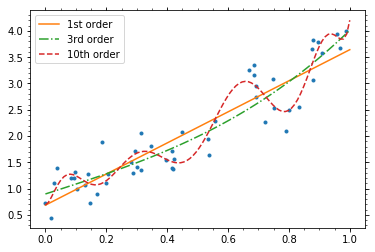

In [16]:
y_pl2_pred = polynomial_expr(x_pl, 10) @ w_lb2
ax0.plot(x_pl, y_pl2_pred, ls='--', label='10th order')
ax0.legend()
fg0

In [17]:
print('Training set:')
y_pred = X_lb2@w_lb2 # a@b=np.dot(a, b) for Python 3
metric_continuous(y_pred, y)

print('Test set:')
y_test_pred = polynomial_expr(X_test_raw, 10) @w_lb2
metric_continuous(y_test_pred, y_test)

Training set:
MSE=0.0743
RSE=0.2782
R2=92.2876%
Test set:
MSE=0.1977
RSE=0.4635
R2=80.6110%


In [18]:
# L2 regularized model
C = 1. # regularized factor
I = np.diag([0.]+[1.]*10) # do not regularize the interception
w_lb2r = np.linalg.inv(X_lb2.T @ X_lb2 + 1./C*I) @ X_lb2.T @ y
w_lb2r

array([[ 1.10252957],
       [ 1.03746549],
       [ 0.75820946],
       [ 0.50549731],
       [ 0.32561311],
       [ 0.20343687],
       [ 0.12178762],
       [ 0.06753389],
       [ 0.03138663],
       [ 0.00699571],
       [-0.00987496]])

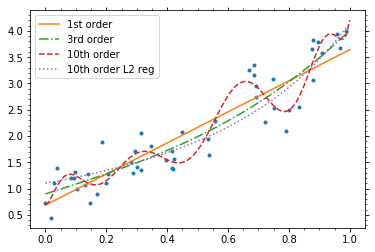

In [19]:
y_pl2r_pred = polynomial_expr(x_pl, 10) @ w_lb2r
ax0.plot(x_pl, y_pl2r_pred, ls=':', label='10th order L2 reg')
ax0.legend()
fg0

In [20]:
print('Training set:')
y_pred = X_lb2@w_lb2r # a@b=np.dot(a, b) for Python 3
metric_continuous(y_pred, y)

print('Test set:')
y_test_pred = polynomial_expr(X_test_raw, 10)@w_lb2r
metric_continuous(y_test_pred, y_test)

Training set:
MSE=0.1385
RSE=0.3799
R2=85.6234%
Test set:
MSE=0.1648
RSE=0.4232
R2=83.8400%


### sklearn

In [21]:
lin3 = linear_model.Ridge(alpha=1.) # alpha=1/C
lin3.fit(X_lb2[:, 1:], y)
print(lin3.intercept_, lin3.coef_) # b, w

[1.10252957] [[ 1.03746549  0.75820946  0.50549731  0.32561311  0.20343687  0.12178762
   0.06753389  0.03138663  0.00699571 -0.00987496]]


## 局部加权线性回归（LWR）
LWR的思想：对于一个要预测的点，只用训练集中与它相近的点来拟合线性模型， 这使得LWR能应对更复杂的数据。   
具体来讲，对于一个给定的点${\bf x}$要训练如下的模型：  
损失函数：$J({\bf \hat w}) = ({\bf Xw-y})^T M_{\bf x} ({\bf Xw-y})$，其中$M_{\bf x}$为权重矩阵，通常选择为高斯函数形式：$M_{\bf x} = {\rm diagonal}( \exp[-({\bf x} - {\bf x}_i)^2/(2\tau^2)])$。  
通过最小化损失函数可得：$\boxed{ {\bf \hat w}_{\bf x}^\star = ({\bf X}^T M_{\bf x} {\bf X})^{-1} {\bf X}^T M_{\bf x} {\bf y}}$。

In [22]:
def lwr_model(X, X_train, y_train, tau=1.):
    """
    Parameters
    -------------
    X : numpy array, (m', n)
        the input feature to infer
    X_train : numpy array, (m, n)
        features of the training sample
    y_train : numpy array, (m, 1)
        output of the training sample
    tau : float, >0., default: 1.
        the sigma in the Gaussian distribution
        
    Returns
    ---------
    y_pred : numpy array, (m', 1)
        the predicted output of the given feature
    """
    if X.ndim == 1:
        X = X.reshape(1, -1)
    y_pred = []
    for i in range(X.shape[0]):
        sqdist = ((X_train - X[i, :])**2).sum(axis=1)
        M = np.diag(np.exp(-sqdist/2./tau**2))
        w = np.linalg.inv(X_train.T@M@X_train) @ X_train.T @ M @ y_train
        y_pred.append(X[i, :]@w)
    return np.array(y_pred).reshape(-1, 1)

In [23]:
# more complex data generator
def mock_generator2(X_raw):
    nsamp = X_raw.shape[0]
    return 1.+X_raw+X_raw**2 + X_raw**3 + 0.25*np.sin(4*2.*np.pi*X_raw) + 0.2*np.random.randn(nsamp)

# training data
X1_raw = np.random.rand(100)
y1_raw = mock_generator2(X1_raw)
X1 = polynomial_expr(X1_raw, 1) # np.c_[np.ones_like(X1_raw), X1_raw]
y1 = y1_raw.reshape(-1, 1)

# test data
X1_test_raw = np.random.rand(50)
y1_test_raw = mock_generator2(X1_test_raw)
X1_test = polynomial_expr(X1_test_raw, 1) # np.c_[np.ones_like(X1_test_raw), X1_test_raw]
y1_test = y1_test_raw.reshape(-1, 1)

In [24]:
# 3rd order LBF
X1_lb = polynomial_expr(X1_raw, 3)
w1_lb = np.linalg.inv(X1_lb.T @ X1_lb) @ X1_lb.T @ y1
y1_pl_lb_pred = polynomial_expr(x_pl, 3) @ w1_lb

# LWR
y1_pl_lwr_pred = lwr_model(polynomial_expr(x_pl), X1, y1, tau=0.02)

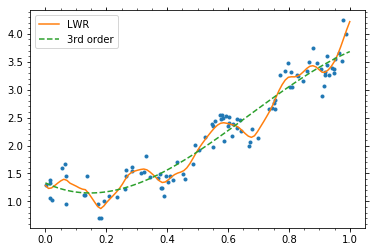

In [25]:
fg1, ax1 = plt.subplots()
ax1.plot(X1[:, 1], y1, marker='o', ms=3, ls='None')
ax1.plot(x_pl, y1_pl_lwr_pred, ls='-', label='LWR')
ax1.plot(x_pl, y1_pl_lb_pred, ls='--', label='3rd order')
ax1.legend()

In [26]:
# 拟合优度
print('----- 3rd-order LBF -----')
print('Training set:')
y1_pred = X1_lb@w1_lb
metric_continuous(y1_pred, y1)

print('Test set:')
y1_test_pred = polynomial_expr(X1_test_raw, 3) @w1_lb
metric_continuous(y1_test_pred, y1_test)

print('----- LWR -----')
print('Training set:')
y1_pred2 = lwr_model(X1, X1, y1, tau=0.02)
metric_continuous(y1_pred2, y1)

print('Test set:')
y1_test_pred2 = lwr_model(X1_test, X1, y1, tau=0.02)
metric_continuous(y1_test_pred2, y1_test)

----- 3rd-order LBF -----
Training set:
MSE=0.0641
RSE=0.2557
R2=91.9074%
Test set:
MSE=0.0586
RSE=0.2471
R2=91.5447%
----- LWR -----
Training set:
MSE=0.0249
RSE=0.1593
R2=96.8572%
Test set:
MSE=0.0426
RSE=0.2108
R2=93.8498%


## 核技巧
当特征空间维度很高时，计算基函数间的内积将很耗计算时间。但从线性基函数的例子中我们可见，核函数可以通过基函数内积获得：$\kappa({\bf x}_1, {\bf x}_2) = \phi({\bf x}_1)^T \phi({\bf x}_2)$。更一般的来看，根据下面两定理，我们可以直接使用核函数来完全回避掉基函数的内积，从而隐式地在高维特征空间中学习线性模型，这个方法称为**核技巧**：

**核函数**：（定理6.1）令$\mathcal{X}$为输入空间，$\kappa(\cdot, \cdot)$是定义在$\mathcal{X} \times \mathcal{X}$上的对称函数，则$\kappa$是核函数当且仅当对于**任意**数据$D=\{{\bf x}_1, {\bf x}_2, \cdots, {\bf x}_m\}$，核矩阵$K = (\kappa({\bf x}_i, {\bf x}_j))$总是*半正定*的。  
也就是说，对称函数的半正定矩阵总能作为核函数使用，并且隐式地定义了一个名为**再生核希尔伯特空间**的特征空间（这个特征空间中的向量可以构造为$\phi_x(\cdot) = K(\cdot, x)$，线性组合定义为$f(\cdot) = \sum_i a_i \phi_{x_i}(\cdot)$，内积定义为$\phi_{x_i}(\cdot) \cdot \phi_{x_j}(\cdot) = K(x_i, x_j)$，范数定义为$\| f \| = \sqrt{f \cdot f}$，完备化后就可形成一个完备的赋范向量空间，而完备的赋范向量空间是希尔伯特空间。再生核指的是核$K$具有再生性：$K(\cdot, x) \cdot f(\cdot) = \sum_i \alpha_i K(x, x_i) = f(x)$，更特别的有$K(\cdot, x) \cdot K(\cdot, z) = K(x, z)$，见统计学习方法7.3.2节）。

**表示理论**：令${\Bbb H}$为核函数$\kappa$对应的再生核希尔伯特空间，$\|h\|_{\Bbb H}$表示${\Bbb H}$空间中关于$h$的范数，对于任意单调递增函数$\Omega: [0,\infty] \mapsto {\Bbb R}$和任意非负损失函数$\ell: {\Bbb R}^m \mapsto [0, \infty]$，优化问题 
$\min_{h \in {\Bbb H}} F(h) = \Omega(\|h\|_{\Bbb H})  +  \ell(h({\bf x}_1), h({\bf x}_2), \cdots, h({\bf x}_m))$
的解总可以写为
$h^\star({\bf x}) = \sum_{i=1}^m \alpha_i \kappa({\bf x}, {\bf x}_i)$。  
也就是说，对于一般的损失函数和正则项，上述优化问题的最优接总可写成核函数的线性组合的形式。

核函数包括：
- 常用核函数：


 名称             |                             $\kappa({\bf x}_i,{\bf  x}_j)$表达式                       | 参数 
--------------|-------------------------------------------------------------------------|-------
线性核           | $ {\bf x}_i^T {\bf x}_j$                                                                      |
多项式核       |  $ (\gamma {\bf x}_i^T {\bf x}_j + r)^d$                                          | $d \geq 1$
高斯核/RBF核| $\exp \left (-\frac{\| {\bf x}_i - {\bf x}_j \|^2}{2\sigma^2} \right )$  | $\sigma > 0$
拉普拉斯核    | $\exp \left (-\frac{\| {\bf x}_i - {\bf x}_j \|}{\sigma} \right )$             | $\sigma > 0$
Sigmoid核    | $\tanh (\beta {\bf x}_i^T {\bf x}_j + \theta)$                                    | $\beta>0,\theta<0$


- 常用核函数的组合：
    + 线性组合：$\gamma_1 \kappa_1 + \gamma_2 \kappa_2$，($\gamma_1, \gamma_2 > 0$)
    + 直积：$ \kappa_1({\bf x, z}) \otimes  \kappa_2({\bf x, z})$
    + 线性变换：$g(\bf x) \kappa({\bf x, z}) g({\bf z})$，($g({\bf x})$为任意函数)
    
### 核岭回归(KRR)
TODO

In [27]:
# TODO: example

# 广义线性模型(Generalized Linear Models, GLMs)
参数$\eta$的**指数分布簇**(Exponential family)：$ p(y; \eta) = b(y) \exp(\eta^T T(y) - a(\eta)) $，其中$\eta$是分布的参数；$T(y)$是**充分统计量**(sufficient statistic)；$a(\eta)$是**对数配分函数**(log partition function)，用于归一化。给定一组$T, a, b$，就定义了一个参数为$\eta$的指数分布簇。  
伯努利分布，高斯分布，多项分布，泊松分布等分布都是指数分布族。

广义线性模型满足：
1. $y \mid x; \theta$服从参数$\eta$的指数分布簇。
3. 参数$\eta$与输入值$x$线性相关：$\eta=\theta^T x$。
2. 预测的目标：给定$\eta$后的充分统计量$T(y)$的期望$g(y) = E[T(y); \eta]$，其中$g(\cdot)$称为**联系函数**（link function）。通常$T(y)=y$ 。

## 对数几率回归(Logistic Regression, LR)  
**几率**指事件发生的概率与不发生的概率的比值。设事件$y=1$发生的概率为$p = p(y=1 \mid {\bf x})$, 因此对数几率（logit）写作为$\ln (p/(1-p))$。对于对数几率回归，输出$y=1$的对数几率是输入的线性函数（为了使概率永远落在$[0, 1]$），或$p=1/[1+\exp(-{\bf \hat w}^T {\bf x})]$。  
损失函数正比于伯努利分布样本的对数似然函数：
$J({\bf \hat w}) = -1/m \sum_{i=1}^{m} [ y_i \ln p_i + (1-y_i) \ln (1-p_i) ]$，$y_i \in {0, 1}$。  
因此，对数几率回归的梯度下降可写为：$\boxed{w_{i+1} = w_{i} - \eta \nabla_{\bf w}J = w_i + \eta {\bf X}^T ({\bf y} - {\bf p}) / m}$，其中$\nabla_{\bf w} p = {\bf x}^T \cdot (p(1-p))$。

当对一个新样本做推断时：我们可以代入${\bf \hat w}$计算$p = p(y=1 \mid {\bf x})$，通过给$p$设一个临界值（如0.5）来判断这个样本的所属。

**对数几率回归的特点**  
优点: 计算代价不高，易于理解和实现。  
缺点: 容易欠拟合，分类精度可能不高。  
适用数据类型: 数值型和标称型数据。

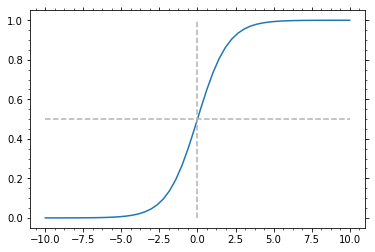

In [28]:
# Logistc function
x_ = np.linspace(-10., 10., 50)
fg3, ax3 = plt.subplots()
ax3.plot(x_, 1./(1.+np.exp(-x_)))
ax3.plot([0., 0.], [0., 1.], ls='--', c='0.7')
ax3.plot([-10., 10.], [0.5, 0.5], ls='--', c='0.7')

**下面是个例子**

In [29]:
# 西瓜书 数据3.0alpha
#!cat datasets/wm3alpha.dat

In [30]:
raw_data2 = np.loadtxt('datasets/wm3alpha.dat')
X2 = raw_data2[:, 1:-1]
y2 = raw_data2[:, -1:]
print(X2.shape, y2.shape)

(17, 2) (17, 1)


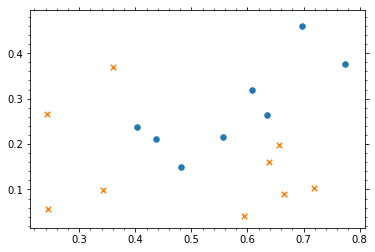

In [31]:
fg, ax = plt.subplots()
ax.scatter(X2[:8, 0], X2[:8, 1], marker='o', s=30)
ax.scatter(X2[8:, 0], X2[8:, 1], marker='x', s=30)

In [32]:
def logistic_model(X, w):
    """
    The model of Logistic regression
    
    Parameters
    ------------
    X : (m, n+1) array
        m training samples with n features
        x=(1, x_1, x_2, ..., x_n)
    w : (n+1, 1) array
        weights (b, w_1, w_2, ..., w_n)
        
    Returns
    ---------
    y_pred : (m, 1) array
        predicted labels
    """
    return 1./(1.+np.exp(-X@w))

def logistic_loss(X, y, w):
    """
    Parameters
    ------------
    X : (m, n+1) array
        m training samples with n features
        x=(1, x_1, x_2, ..., x_n)
    y : (m, 1) array, yi=0 or 1
        the labels of m training samples
    w : (n+1, 1) array
        weights (b, w_1, w_2, ..., w_n)
    
    Returns
    ---------
    loss : scalar
        the log likelihood per sample
    """
    p = logistic_model(X, w)
    loss = -(y*np.log(p) + (1-y)*np.log(1.-p)).mean()
    return loss

In [33]:
# learning the logistic model
nepoch = 1000
learning_rate = 3.

m, n = X2.shape
w = np.zeros((n+1, 1))
X2_ = np.c_[np.ones(m), X2]

# gradient descent
losses = []
for i in range(nepoch):
    w += X2_.T @ (y2 - logistic_model(X2_, w)) / m * learning_rate
    losses.append(logistic_loss(X2_, y2, w))
    if i%100 == 0 or i+1 == nepoch:
        print(i, w.ravel(), losses[-1])

0 [-0.08823529  0.01102941  0.07429412] 0.6892355723476886
100 [-2.2507477   1.8010459   5.59195891] 0.5515435135858472
200 [-3.07050222  2.29625924  8.20631096] 0.5248925458707252
300 [-3.51691445  2.55140098  9.68644794] 0.5165514277515946
400 [-3.79807834  2.72130813 10.60092368] 0.5133592718269573
500 [-3.98620273  2.84262835 11.19525318] 0.5119991073601865
600 [-4.11571154  2.93047777 11.59410068] 0.5113809717178437
700 [-4.2062315   2.99411077 11.86749731] 0.5110883196402102
800 [-4.27007027  3.04010073 12.05761094] 0.5109459819197901
900 [-4.31535086  3.07327105 12.1911221 ] 0.510875482670161
999 [-4.34732078  3.09695873 12.28473474] 0.5108403730213498


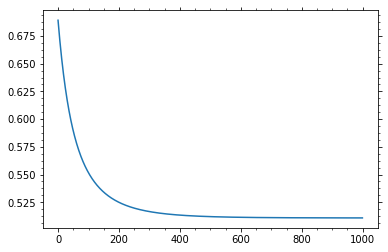

In [34]:
# learning curve
fg1, ax1 = plt.subplots()
ax1.plot(losses)

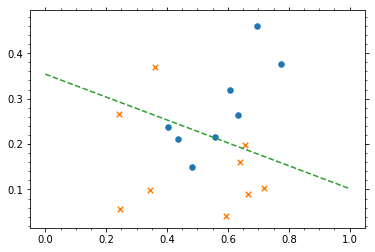

In [35]:
# decision boundary
_x = np.linspace(0., 1., 2)
ax.plot(_x, -(w[0]+w[1]*_x)/w[2], ls='--', c='C2')
fg

In [36]:
def accuracy(y_pred, y_truth):
    """
    Accuracy: #right / #all
    
    Parameters
    -------------
    y_pred : numpy array, (m, 1)
        the predicted labels
    y_truth : numpy array, (m, 1)
        the true labels
        
    Returns
    --------
    accuracy : double
        larger is better
    """
    return (y_pred == y_truth).sum()/y_truth.shape[0] # right/all

def precision(y_pred, y_truth):
    """
    Precision: #true_positive / #pred_positive
    
    Parameters
    -------------
    y_pred : numpy array, (m, 1)
        the predicted labels
    y_truth : numpy array, (m, 1)
        the true labels
        
    Returns
    --------
    precision : double
        larger is better
    """
    return ((y_pred==1) & (y_truth == 1)).sum()/(y_pred == 1).sum() # tp / pred pos

def recall(y_pred, y_truth):
    """
    Recall: #true_positive / #positive
    
    Parameters
    -------------
    y_pred : numpy array, (m, 1)
        the predicted labels
    y_truth : numpy array, (m, 1)
        the true labels
        
    Returns
    --------
    recall : double
        larger is better
    """
    return ((y_pred==1) & (y_truth == 1)).sum()/(y_truth == 1).sum() # tp / pos

def fbeta_score(y_pred, y_truth, beta=1.):
    """
    F_beta score

    Parameters
    -------------
    y_pred : numpy array, (m, 1)
        the predicted labels
    y_truth : numpy array, (m, 1)
        the true labels
    beta : double, >0. default: 1.
        
    Returns
    --------
    fbeta_score : double
        larger is better
    """
    prec = precision(y_pred, y_truth)
    reca = recall(y_pred, y_truth)
    return (1+beta**2)/(1/prec + beta**2/reca)

In [37]:
# metrics
y2_pred = logistic_model(X2_, w) > 0.5
print("accuracy = {:.2%}".format(accuracy(y2_pred, y2)))
print('precision={:.2%}'.format(precision(y2_pred, y2)))
print('recall={:.2%}'.format(recall(y2_pred, y2)))
print('f1={:.2%}'.format(fbeta_score(y2_pred, y2)))
print('f2={:.2%}'.format(fbeta_score(y2_pred, y2, beta=2.)))

accuracy = 70.59%
precision=71.43%
recall=62.50%
f1=66.67%
f2=64.10%


### sklearn

In [38]:
# learning the logistic model with sklearn
log = linear_model.LogisticRegression(C=10000.)
log.fit(X2, y2.ravel())

LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [39]:
print(log.coef_, log.intercept_) # (w1, w2, b)

[[ 3.14089155 12.45455489]] [-4.40581073]


In [40]:
y2_pred_ = log.predict(X2)
print('accuracy={:.2%}'.format(metrics.accuracy_score(y2, y2_pred_)))
print('precision={:.2%}'.format(metrics.precision_score(y2, y2_pred_)))
print('recall={:.2%}'.format(metrics.recall_score(y2, y2_pred_)))
print('f1={:.2%}'.format(metrics.f1_score(y2, y2_pred_)))
print('f2={:.2%}'.format(metrics.fbeta_score(y2, y2_pred_, beta=2)))

accuracy=70.59%
precision=71.43%
recall=62.50%
f1=66.67%
f2=64.10%


## 多项对数几率回归/Softmax回归
将对数几率回归这个二分类模型推广到多分类模型：  
$p(y=k \mid {\bf x}) = \frac{\exp({\bf \hat w}_k^T {\bf x})}{1 + \sum_{i=1}^{K-1} \exp({\bf \hat w}_i^T {\bf x}) }$ (for $k=1, 2, \cdots, K-1$) and   
$p(y=K \mid {\bf x}) = \frac{1}{1 + \sum_{i=1}^{K-1} \exp({\bf \hat w}_i^T {\bf x}) }$。  
损失函数：$J({\bf \hat w}) = -1/m \sum_{i=1}^{m} \sum_j 1\{ y_i = j\} \ln p (y=j \mid {\bf x}_i; {\bf \hat w})$。  
梯度下降：$\boxed{w_{k, i+1} = w_{k, i} - \eta \nabla_{\bf w_k}J = w_{k, i} + \eta {\bf X}^T ({\bf 1}\{ y=k \} - {\bf p}(y=k)) / m}$ (for $k=1, 2, \cdots, K-1$)。

In [41]:
# TODO: example

# 判别式分析（Discriminant Analysis）
判别式分析是一个贝叶斯分类算法，它在算法上相比于LR更加稳定，且在多分类问题中较为常用。

从贝叶斯分析的角度，如果给定一个输入$\bf x$，那么后验概率$P(Y=k | X={\bf x})$中最大的类别就是最佳的类别。  
根据贝叶斯定理，$P(Y=k | X={\bf x}) \propto \pi_k P(X={\bf x}| Y=k)$。其中，$\pi_k$为类别$k$的数据的先验分布，对于给定的训练集可以用类别为$k$的样本数$n_k$除以总样本数$N$来估计，即${\hat \pi}_k=n_k/N$。而$P(X={\bf x}| Y=k)$为类别$k$的样本中特征$\bf x$的条件概率密度分布，在判别式分析中，它被简单地假设为高斯分布。

在线性判别式分析中，所有类别的条件概率高斯分布都假设为同一个协方差矩阵；而二次别式分析中，则没有这个简化。

<img src="figures/lda_qda.png" width="60%" height="60%" align=center />

## 线性判别式分析（LDA）

对于类别$k$的高斯分布，有$P(X={\bf x}| Y=k) = \frac{1}{\sqrt{(2\pi)^p |\Sigma|}} \exp \left [ -\frac{1}{2} ({\bf x}-{\bf \mu}_k)^T \Sigma^{-1} ({\bf x}-{\bf \mu}_k) \right ]$。  
如果要求输入特征$\bf x$的后验概率在$Y=k$时最大，则等价于要求对于这个输入判别式$\delta_k({\bf x}) = {\bf x}^T \Sigma^{-1} {\bf \mu}_k - \frac{1}{2} {\bf \mu}_k^T \Sigma^{-1} {\bf \mu}_k + \ln \pi_k$在所有$\delta_Y$中取值最大。 
其中，对于给定的训练集，均值${\bf \hat \mu}_k = \frac{1}{n_k} \sum_{\{i| y_i =k \}} {\bf x}_i$，协方差${\hat \Sigma} = \frac{1}{N-K} \sum_{k=1}^K \sum_{\{i|y_i = k \}} ({\bf x}_i - {\bf \hat \mu}_k)  ({\bf x}_i - {\bf \hat \mu}_k)^T$。  
因为上述的判别式是线性的，所以称这个算法是**线性判别式算法**。 

两个类别数据的决策边界满足$\delta_k({\bf x}) = \delta_l({\bf x})$，或者${\bf x}^T \Sigma^{-1} ({\bf \mu}_k - {\bf \mu}_l) - \frac{1}{2} ( {\bf \mu}_k^T \Sigma^{-1} {\bf \mu}_k - {\bf \mu}_l^T \Sigma^{-1} {\bf \mu}_l) + (\ln \pi_k - \ln \pi_l) = 0$，它是由两个高斯分布相交的部分构成的一个平面。
换个角度来看，上述平面的法线方向是能比较好地把这两类数据分开的方向。事实上，*如果将数据点投影到某两类数据决策平面的法线方向上，就能使得同类样例尽可能靠近、异类样例尽量远离，因此能作为一个降维的方案*。下面做出证明。  

若把一个点$({\bf x}, y)$投影到方向向量为${\bf w}$的直线上，则有${\bf w}^T {\bf x}$。  
为了扩大差异，优化目标设为（分子上是类间的差别，分母上是累内的差别，所以需要使$J$最大）：
$ J = \frac{\| {\bf w}^T {\bf \mu}_0 - {\bf w}^T {\bf \mu}_1 \| ^2}{{\bf w}^T ({\bf \Sigma_0 + \Sigma_1}) {\bf w}} = \frac{{\bf w}^T {\bf S}_b {\bf w}}{{\bf w}^T {\bf S}_w {\bf w}}  $，  
其中
${\bf S}_w = \sum_{{\bf x} \in X_0} ({\bf x-{\mu}}_0)({\bf x-{\mu}}_0)^T + \sum_{{\bf x} \in X_1} ({\bf x-{\mu}}_1)({\bf x-{\mu}}_1)^T$，
${\bf S}_b = ({\bf \mu_0 - \mu_1})({\bf \mu_0 - \mu_1})^T $，  
可得，因为我们只需要$\bf w$的方向，可以通过增加限定${\bf w}^T {\bf S}_b {\bf w}=1$来唯一确定$\bf w$的取值。  
罪过Lagrange乘子法易得，$\boxed {{\bf w} = -\lambda S_w^{-1} S_b {\bf w} \propto S_w^{-1} ({\bf \mu_0 - \mu_1})}$ (考虑到$S_b {\bf w}$方向和${\bf \mu_0 - \mu_1}$一致)。

In [42]:
#!head datasets/MLiA/Ch05/testSet.txt # MLiA, Chapter05

In [43]:
raw_data = np.loadtxt('datasets/MLiA/Ch05/testSet.txt')

X2 = raw_data[:, :2]
y2 = raw_data[:, 2]

X2_0 = X2[y2==0, :]
X2_1 = X2[y2==1, :]

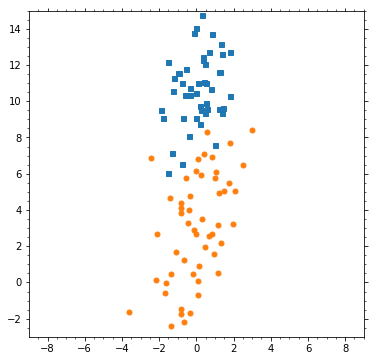

In [44]:
fg2, ax2 = plt.subplots(figsize=(6, 6))
ax2.plot(X2_0[:, 0], X2_0[:, 1], marker='s', ms=5, c='C0', ls='None')
ax2.plot(X2_1[:, 0], X2_1[:, 1], marker='o', ms=5, c='C1', ls='None')

xmin, xmax = ax2.set_xlim([-9, 9])
ymin, ymax = ax2.set_ylim([-3, 15])

In [45]:
m = X2.shape[0]

# priors
pi0 = X2_0.shape[0]/m
pi1 = X2_1.shape[0]/m
print('pi0={}, pi1={}'.format(pi0, pi1))

# means
mu0 = X2_0.mean(axis=0, keepdims=True)
mu1 = X2_1.mean(axis=0, keepdims=True)
print('mu_0={}, mu_1={}'.format(mu0, mu1))

# covariances
Sw = ((X2_0-mu0).T@(X2_0-mu0) + (X2_1-mu1).T@(X2_1-mu1))/(m-2) # X=(nsamples, nfeatures)
print('Sw = \n', Sw)

# inverse of the covariances
u, s, v = np.linalg.svd(Sw) # singular value decomposition: Sw = u@diag(s)@v
Sw_inv = v.T@np.diag(1./s)@u.T
print('Sw^-1 = \n', Sw_inv)
#print(np.linalg.inv(Sw))

pi0=0.47, pi1=0.53
mu_0=[[ 0.08204613 10.65488423]], mu_1=[[-0.01613109  2.95908379]]
Sw = 
 [[1.38121466 1.34209879]
 [1.34209879 6.74153298]]
Sw^-1 = 
 [[ 0.89764129 -0.17870168]
 [-0.17870168  0.18391   ]]


**分类**

In [46]:
# descriminant functions
b_delta0 = - 0.5 * mu0@Sw_inv@mu0.T + np.log(pi0)
b_delta1 = - 0.5 * mu1@Sw_inv@mu1.T + np.log(pi1)

delta0 = lambda X: X@Sw_inv@mu0.T + b_delta0
delta1 = lambda X: X@Sw_inv@mu1.T + b_delta1

In [47]:
# decision boundary: x.T @ w_db + b_db = 0 
w_db = Sw_inv@(mu0-mu1).T
b_db = b_delta0 - b_delta1
print('w={}, b={}'.format(w_db, b_db))

w=[[-1.28712456]
 [ 1.3977902 ]], b=[[-9.59245945]]


In [48]:
# classify test
X2_test = np.array([[-2., 5.], [0., 7.], [2., 8.]])
y2_test_pred = np.where( delta0(X2_test)>delta1(X2_test), 0, 1).reshape(-1, 1)
y2_test_pred

array([[1],
       [0],
       [1]])

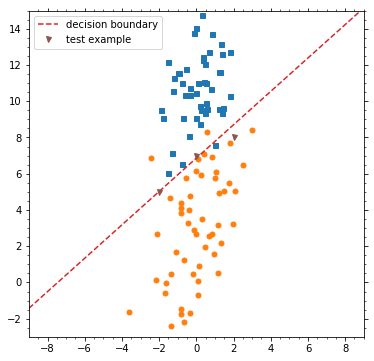

In [49]:
x_pl = np.array([xmin, xmax])
ax2.plot(x_pl, (-b_db[0, 0]-w_db[0, 0]*x_pl)/w_db[1, 0], ls='--', c='C3', label='decision boundary')
ax2.plot(X2_test[:, 0], X2_test[:, 1], marker='v', c='C5', ms=5, ls='None', label='test example')
ax2.legend()
fg2

**降维**

In [50]:
# dimension reduction
w_db_norm = w_db/np.sqrt((w_db**2).sum())
X_proj = X2@w_db_norm
print('X_proj[:10] = ', X_proj[:10])

X_proj[:10] =  [[10.34974892]
 [ 4.37527637]
 [ 5.31948889]
 [ 6.15759072]
 [ 7.84534285]
 [ 4.92342944]
 [ 8.92087745]
 [ 6.71788201]
 [ 6.63861445]
 [ 7.68897352]]


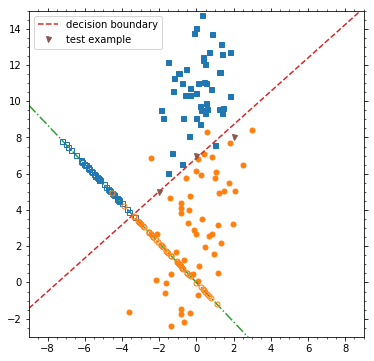

In [51]:
# the line to project, let (x-0)/w0 = (y-0)/w1
y_pl2 = w_db[1, 0]/w_db[0, 0]*x_pl
ax2.plot(x_pl, y_pl2, ls='-.', c='C2')

# project points to normal vector: x_new = (x@w) * w/|w|^2
X2_0_proj = (X2_0@w_db_norm) * w_db_norm.T
X2_1_proj = (X2_1@w_db_norm) * w_db_norm.T
ax2.plot(X2_0_proj[:, 0], X2_0_proj[:, 1], marker='s', ms=5, c='C0', mfc='None', ls='None')
ax2.plot(X2_1_proj[:, 0], X2_1_proj[:, 1], marker='o', ms=5, c='C1', mfc='None', ls='None')
fg2

## 二次判别分析(QDA)

二次判别分析不要求每一类的高斯分布具有同样的协方差，无法消去二次项，因此判别式只能写为：$\delta_k({\bf x}) = -\frac{1}{2} ({\bf x}-{\bf \mu}_k)^T \Sigma_k^{-1} ({\bf x}-{\bf \mu}_k) - \frac{1}{2} \ln | \Sigma_k | + \ln \pi_k$。因为这个判别式是二次函数，所以该算法称为**二次判别分析**。

因为判别式为二次的，决策边界也会是一个二次的面。

In [52]:
# covariances
Sw0 = (X2_0-mu0).T@(X2_0-mu0)/(X2_0.shape[0]-1)
print('Sw0 = \n', Sw0)
u, s, v = np.linalg.svd(Sw0)
Sw0_inv = v.T@np.diag(1./s)@u.T
print('Sw0^-1 = \n', Sw0_inv)

Sw1 = (X2_1-mu1).T@(X2_1-mu1)/(X2_1.shape[0]-1)
print('Sw1 = \n', Sw1)
u, s, v = np.linalg.svd(Sw1)
Sw1_inv = v.T@np.diag(1./s)@u.T
print('Sw1^-1 = \n', Sw1_inv)

Sw0 = 
 [[0.9579532  0.54249108]
 [0.54249108 3.70851954]]
Sw0^-1 = 
 [[ 1.13817915 -0.16649556]
 [-0.16649556  0.29400475]]
Sw1 = 
 [[1.75563826 2.04944407]
 [2.04944407 9.42458334]]
Sw1^-1 = 
 [[ 0.76337523 -0.16600149]
 [-0.16600149  0.14220371]]


In [53]:
# descriminant functions
b_delta0_qda = -0.5*np.log(np.linalg.det(Sw0)) + np.log(pi0)
b_delta1_qda = -0.5*np.log(np.linalg.det(Sw1)) + np.log(pi1)

delta0_qda = lambda X: -np.diag((X-mu0)@Sw0_inv@(X-mu0).T) + b_delta0_qda
delta1_qda = lambda X: -np.diag((X-mu1)@Sw1_inv@(X-mu1).T) + b_delta1_qda

In [54]:
# predict
y2_test2_pred = np.where( delta0_qda(X2_test)>delta1_qda(X2_test), 0, 1).reshape(-1, 1)
y2_test2_pred

array([[1],
       [1],
       [1]])

### LDA、QDA、LR、KNN间的比较
LDA算法与LR算法一样，它的对数几率为线性函数，不过前者的参数通过正态分布的均值和方差来估计的，而后者利用极大似然估计法。这两个方法的性能差别不大，不过当不同类别样本的真实分布确实是协方差类似的高斯分布一致，前者更优。

KNN算法是非参数方法，不对决策边界做假设，因此在高度非线性的情况下，KNN优于LR和LDA。但KNN无法得到不同特征的权重。

QDA假设二次函数形式的决策边界，它在非线性情况下优于LDA和LR，但劣于KNN。但当训练样本较少时，QDA能缓解过拟合的问题，泛化性能可能优于KNN；同时中等非线性的情况下，模型自由度高于LDA和LR，因此泛化性能也会比LR和LDA更优。

## 核线性判别式分析(KLDA)
TODO

## scikit-learn
`sklearn`的`discriminant_analysis`模块实现了`LinearDiscriminantAnalysis`和`QuadraticDiscriminantAnalysis`，详见[官方文档](http://scikit-learn.org/stable/modules/lda_qda.html)。

### LDA

In [55]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X2, y2)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=True, tol=0.0001)

In [56]:
print('prior=', lda.priors_)
print('means=', lda.means_)
print('covar=', lda.covariance_) # probably divide by m not m-2

prior= [0.47 0.53]
means= [[ 0.08204613 10.65488423]
 [-0.01613109  2.95908379]]
covar= [[1.35359036 1.31525681]
 [1.31525681 6.60670232]]


**分类**

In [57]:
print('w={}, b={}'.format(lda.coef_, lda.intercept_))

w=[[ 1.28712456 -1.3977902 ]], b=[9.59245945]


In [58]:
lda.predict(X2_test)

array([1., 0., 1.])

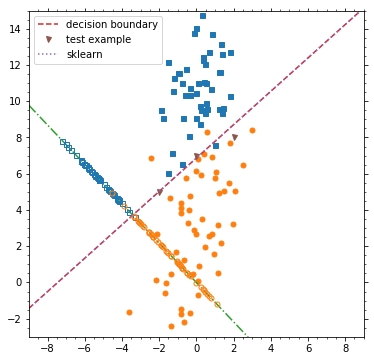

In [59]:
ax2.plot(x_pl, (-lda.intercept_[0]-lda.coef_[0, 0]*x_pl)/lda.coef_[0, 1], ls=':', c='C4', label='sklearn')
ax2.legend()
fg2

**降维**

In [60]:
X2_proj = lda.transform(X2)
X2_proj[:10, :]

array([[-3.22421922],
       [ 0.25756423],
       [-0.29270083],
       [-0.78112706],
       [-1.76470969],
       [-0.06188661],
       [-2.39150621],
       [-1.10765177],
       [-1.06145648],
       [-1.67358129]])

### QDA

In [61]:
qda = discriminant_analysis.QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X2, y2)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=True, store_covariances=None, tol=0.0001)

In [62]:
print('Sw0={},\nSw1={}'.format(*qda.covariance_))

Sw0=[[0.9579532  0.54249108]
 [0.54249108 3.70851954]],
Sw1=[[1.75563826 2.04944407]
 [2.04944407 9.42458334]]


In [63]:
#predict
qda.predict(X2_test)

array([1., 1., 1.])

# 参考资料
1. 机器学习, 周志华, pp. 28-33, 53-63, 126-129, 137-139, 252-254, 399-403.
2. 统计学习方法, 李航, pp. 115-123.
3. 机器学习实战, P. Harrington, pp. 136-149.
4. ISL, G. James, D. Witten, T. Hastie and R. Tibshirani, pp. 68-71, 138-154.
5. CS229 [note1](http://cs229.stanford.edu/notes/cs229-notes1.pdf), A. Ng, pp. 1-30.
6. scikit-learn.org, [1.1. GLMs](http://scikit-learn.org/stable/modules/linear_model.html), [1.2. LDA](http://scikit-learn.org/stable/modules/lda_qda.html).